In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score
import os
import glob
import zipfile
import random

# Nueva sección

In [ ]:
class_names = ["benign", "malignant"]
def download_and_extract_dataset():
  # dataset from https://github.com/udacity/dermatologist-ai
  # 5.3GB
  train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
  # 824.5MB
  valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
  for i, download_link in enumerate([train_url]):
    temp_file = f"temp{i}.zip"
    data_dir = get_file(origin=download_link, fname=os.path.join(os.getcwd(), temp_file))
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(temp_file)

# comment the below line if you already downloaded the dataset
download_and_extract_dataset()

def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

# generate CSV files for all data portions, labeling nevus and seborrheic keratosis
# as 0 (benign), and melanoma as 1 (malignant)
# you should replace "data" path to your extracted dataset path
# don't replace if you used download_and_extract_dataset() function
generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

 712908800/5736557430 [==>...........................] - ETA: 1:59

In [50]:
import torch
from PIL import Image

df_train=pd.read_csv("train.csv")
X_train=[]
for i in df_train[df_train.keys()[1]]:
  img = Image.open(i)
  imgGray = (img.convert('L')).resize((120,120))
 
  X_train.append(np.array(imgGray))



In [ ]:
print(len(X_train))

2000


In [51]:
from sklearn.model_selection import train_test_split
X_train=np.array(X_train)
Y_train=np.array(df_train[df_train.keys()[2]])
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_train,Y_train)

In [37]:
import torch
criterion = torch.nn.CrossEntropyLoss()



```
# Tiene formato de código
```

# Nueva sección

# Red Neuronal

In [59]:
#--- Definimos la CNN
import math
def caract(w,k,p,s):
  return math.floor((w-k-2*p)/s +1)

model = torch.nn.Sequential(

  torch.nn.Conv2d(1, 120, kernel_size=13, stride=1, padding=0),
  
  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),

  torch.nn.Dropout(p=0.2),

  torch.nn.Conv2d(120, 240, kernel_size=5, stride=1, padding=0),
  # ( (5-3+2*2)/1 ) + 1 = 7   -> 7*7*32

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 7/2 = 3                 -> 3*3*32

  torch.nn.Dropout(p=0.2), 

  torch.nn.Flatten(),
  torch.nn.Linear(25*25*240,2)
)
model

Sequential(
  (0): Conv2d(1, 120, kernel_size=(13, 13), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(120, 240, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=150000, out_features=2, bias=True)
)

In [53]:

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [54]:
batch_size = 32
train_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_train1).float(), torch.from_numpy(Y_train1))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [ ]:
import torch

In [ ]:
#--- Visualizamos la estructura de nuestra CNN


In [ ]:
pip install hiddenlayer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


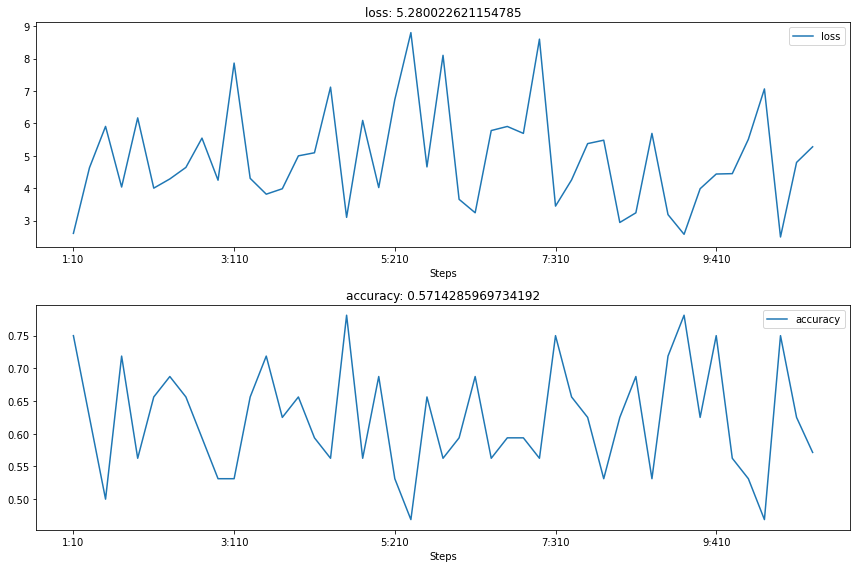

In [60]:
# Entrenamiento red neuronal

import hiddenlayer as hl
from sklearn.metrics import f1_score

n_epoch = 10

history = hl.History()
canvas = hl.Canvas()

model.to(device)


iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

    #-- Cargamos los datos en la GPU
    X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

    model.train()
    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    #-- Calculamos el f1 en la cpu
    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        history.log((epoch+1, iter), loss=loss, accuracy=acc)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])

In [61]:
#-- Validamos el modelo

X_test_tensor, Y_test_tensor = torch.from_numpy(X_test1).float().to(device), torch.from_numpy(Y_test1).to(device)
model.eval()
Y_pred = model(X_test_tensor.unsqueeze(1))

loss = criterion(Y_pred,Y_test_tensor)
Y_pred = torch.argmax(Y_pred, 1)

f1 = f1_score(Y_test_tensor.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_test_tensor == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:1.40, F1:0.48, Acc:0.83


# Nueva sección